In [1]:
# Standard imports
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa

import librosa.display

In [2]:
y, sr = librosa.load('audio/000615.mp3', duration=120)


In [3]:
# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

In [4]:
idx = slice(*librosa.time_to_frames([30, 35], sr=sr))


In [5]:
plt.figure(figsize=(12, 4))


<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

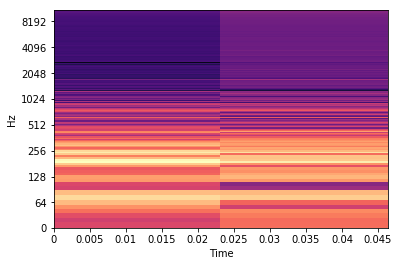

In [6]:
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)

In [8]:
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

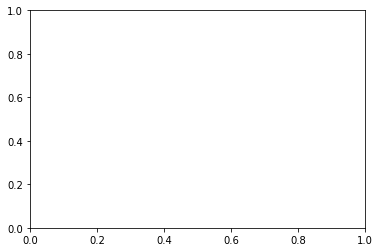

In [10]:
ax=plt.gca() #get the current axes

In [11]:
PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes


AttributeError: 'Spine' object has no attribute 'autoscale_None'

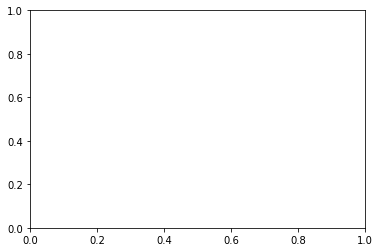

In [12]:
plt.colorbar(PCM, ax=ax) 


In [13]:
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

In [14]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [15]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

In [16]:
# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [17]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

In [18]:
# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

In [19]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

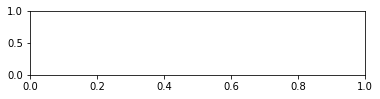

In [20]:
plt.subplot(3, 1, 1)

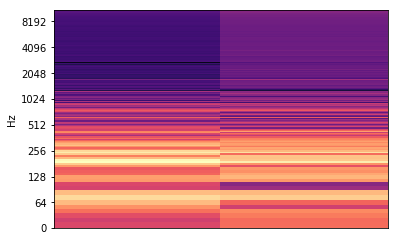

In [21]:
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)

Text(0.5,1,'Full spectrum')

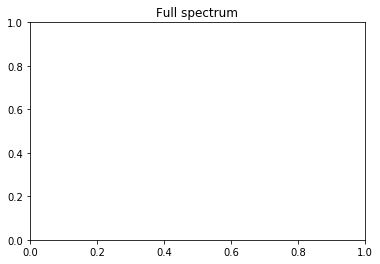

In [22]:
plt.title('Full spectrum')


In [23]:
plt.colorbar()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

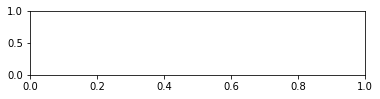

In [24]:
plt.subplot(3, 1, 2)


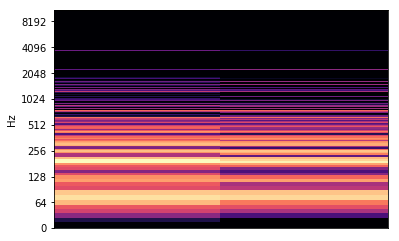

In [25]:
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)

Text(0.5,1,'Background')

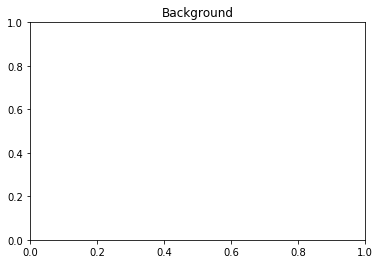

In [26]:
plt.title('Background')

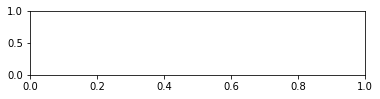

In [27]:
plt.subplot(3, 1, 3)

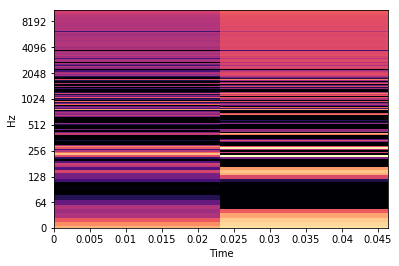

In [28]:
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)

Text(0.5,1,'Foreground')

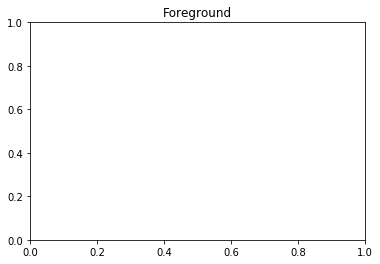

In [29]:
plt.title('Foreground')

In [30]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>